# MNIST vanishing gradients experiment

This experiment tries to check the effects of different weight initializations for the MNIST handwritten digit classification problem. The idea is to create a convolutional neural network, and verify the learnning curves of different initial weight standard deviations.

The expectation was that, as I understand from the [Xavier, Glorot 2010] paper, weight intialization should be important to combat vanishing gradients. However, the experiment shows that this is not the case. Initial weights between $0.0001$ and $1$ standard deviation seem to provide reasonable ($>0.9$ accuracy) results within just $2$ minutes of calculation on a NVidia 960M (laptop-)GPU.

[Xavier, Glorot 2010] http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf

My motivation for this experiment was that the Tensorflow-tutorial on MNIST didn't mention anything about the standard deveation of weight initialization, nor does it use Batch normalization. Hence I was wondering where the $0.1$-values they used came from.

The only reason for this weight-robust performance I can think off at the moment is due to the relative shallow network used.

In [1]:
import time
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
from tensorflow.python.client import device_lib

import numpy
import matplotlib.pyplot as pyplot
%matplotlib inline

# Load the MNIST data

In [2]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


# Create weight variables
(with a certain stddev)

In [3]:
def weight_variable(shape, w=0.1):
  initial = tf.truncated_normal(shape, stddev=w)
  return tf.Variable(initial)

def bias_variable(shape, w=0.1):
  initial = tf.constant(w, shape=shape)
  return tf.Variable(initial)

# Building the network

In [4]:
def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

In [5]:
    def build_network_for_weight_initialization(w):
        """ Builds a CNN for the MNIST-problem:
         - 32 5x5 kernels convolutional layer with bias and ReLU activations
         - 2x2 maxpooling
         - 64 5x5 kernels convolutional layer with bias and ReLU activations
         - 2x2 maxpooling
         - Fully connected layer with 1024 nodes + bias and ReLU activations
         - dropout
         - Fully connected softmax layer for classification (of 10 classes)

         Returns the x, and y placeholders for the train data, the output
         of the network and the dropbout placeholder as a tuple of 4 elements.
        """
        x = tf.placeholder(tf.float32, shape=[None, 784])
        y_ = tf.placeholder(tf.float32, shape=[None, 10])

        x_image = tf.reshape(x, [-1,28,28,1])
        W_conv1 = weight_variable([5, 5, 1, 32], w)
        b_conv1 = bias_variable([32], w)

        h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
        h_pool1 = max_pool_2x2(h_conv1)
        W_conv2 = weight_variable([5, 5, 32, 64], w)
        b_conv2 = bias_variable([64], w)

        h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
        h_pool2 = max_pool_2x2(h_conv2)

        W_fc1 = weight_variable([7 * 7 * 64, 1024], w)
        b_fc1 = bias_variable([1024], w)

        h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
        h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

        keep_prob = tf.placeholder(tf.float32)
        h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

        W_fc2 = weight_variable([1024, 10], w)
        b_fc2 = bias_variable([10], w)

        y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

        return (x, y_, y_conv, keep_prob)

# Experiment setup

Train network 3 times for several weights between $0.0001$ and $1.0$ and plot the learning curve

In [6]:
def evaluate_for_weight_init(w):
    """ Returns an accuracy learning curve for a network trained on
    10000 batches of 50 samples. The learning curve has one item
    every 100 batches."""
    with tf.Session() as sess:
        x, y_, y_conv, keep_prob = build_network_for_weight_initialization(w)
        cross_entropy = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
        train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
        correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        sess.run(tf.global_variables_initializer())
        lr = []
        for _ in range(100):
            for i in range(100):
              batch = mnist.train.next_batch(50)
              train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})
            assert mnist.test.images.shape[0] == 10000
            # This way the accuracy-evaluation fits in my 2GB laptop GPU.
            a = sum(
                accuracy.eval(feed_dict={
                    x: mnist.test.images[2000*i:2000*(i+1)],
                    y_: mnist.test.labels[2000*i:2000*(i+1)],
                    keep_prob: 1.0})
                for i in range(5)) / 5
            lr.append(a)
    return lr

In [7]:
ws = [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1.0]
accuracies = [] # Uncomment to reset the experiment

In [8]:
# Run this cell multiple (3) times to get more 'statistical significance'
accuracies.append([])
for w in ws:
    accuracies[-1].append(evaluate_for_weight_init(w))

In [ ]:
# Run this cell instead of the previous two to run the experiment in one go
ws = [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1.0]
accuracies = [
    [evaluate_for_weight_init(w) for w in ws]
    for _ in range(3)
]

# Results

The plot shows that $>0.1$ standard degrades performance significantly, but still the $0.94$ accuracy is OK and not a sign of vanishing or exploding gradient. The 

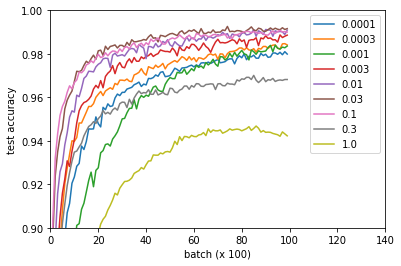

In [10]:
pyplot.plot(numpy.array(accuracies).mean(0).T)
pyplot.ylim(0.9, 1)
pyplot.xlim(0,140)
pyplot.xlabel('batch (x 100)')
pyplot.ylabel('test accuracy')
pyplot.legend(ws)
None